## Maximum Sustainable Throughput Calculator

When publishing feature samples to a Kafka topic, we need to determine what is the maximum throghput we can handle while managing a sub-second latency. This notebook helps us determine the theoretical maximum number.

Theoretical maximum ignores the time it takes for a sample record to be transferred over the network from a Kafka Producer to a Kafka Consumer. When you run the `MaliciousURLModelConsumer.ipynb` notebook you will notice this typically ranges from
`150ms` to `350ms`. You will need to add this to your calculations to determine the practical maximum throughput.

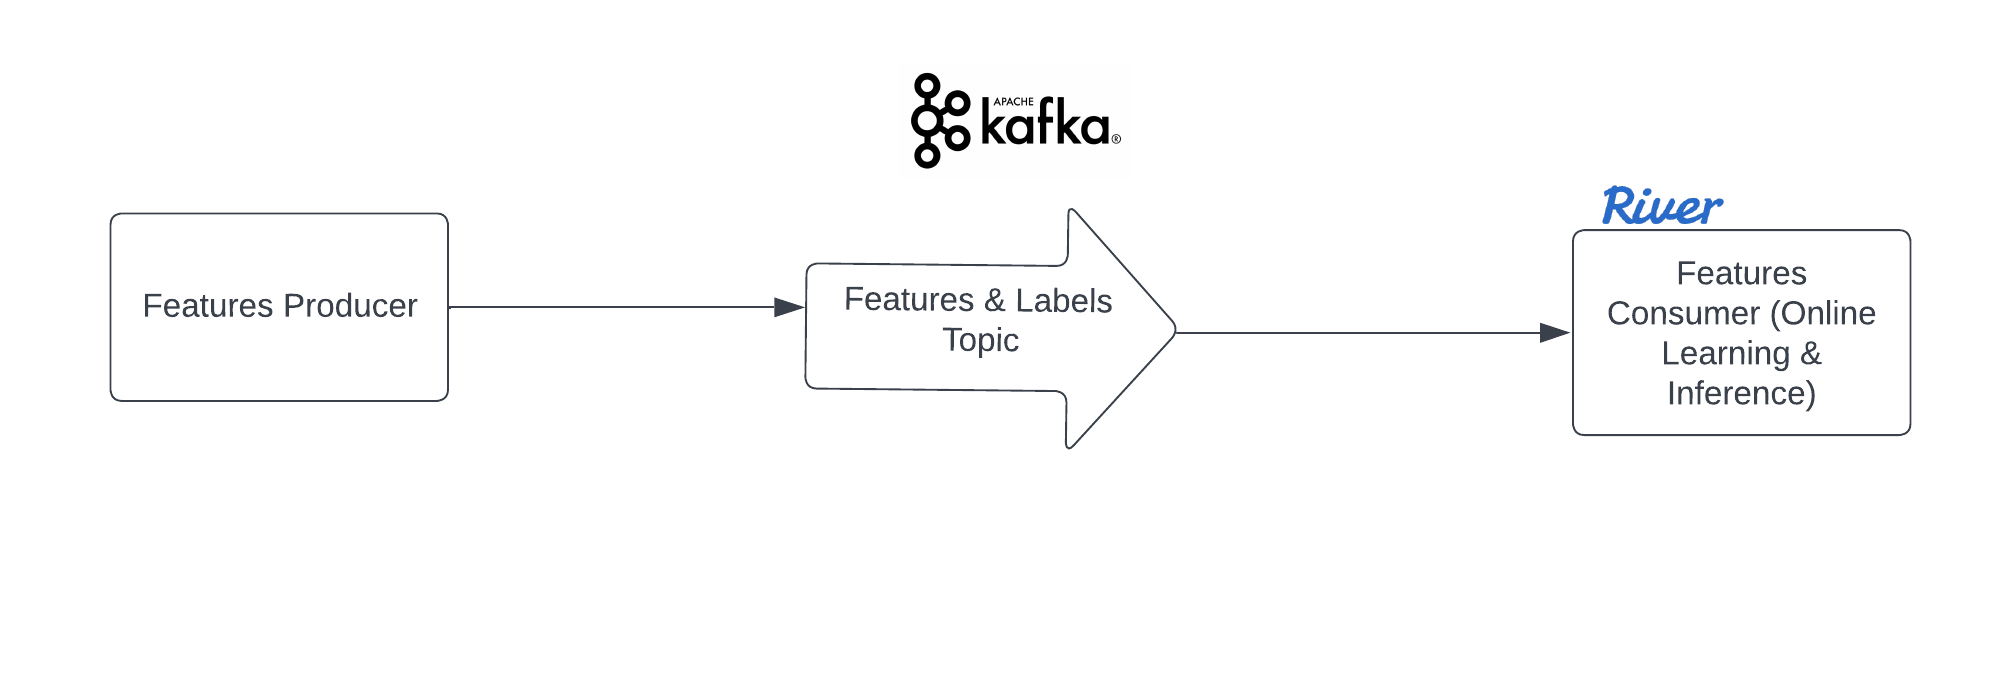

In [1]:
from IPython import display
display.Image('/mnt/code/assets/schematic_design.png')

### Basic Design
1. You can have multiple consumers to process features in parallel
2. For use-cases like Malicious URL detection, this design is appropriate
3. Each consumer trains independently
4. Expectation is that each consumer would eventually converge in a way as to provide identical results as the others for the same feature set
5. Feature set record delivered to a consumer instance in parallel

In [1]:
import os
from river import datasets
from river import metrics
from river import tree
from river import ensemble
from river import evaluate
from river import compose
from river import naive_bayes
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from confluent_kafka import Producer,Consumer
import certifi
import time
import json
import pandas

### Classifiers Used

The throughput and latency depends on the classifier used. We use the classifiers below

In [2]:
classifiers=[]
classifier='HoeffdingAdaptiveTreeClassifier'
classifiers.append(classifier)
classifier='SRPClassifierHAT'
classifiers.append(classifier)
classifier='SRPClassifierNaiveBayes'
classifiers.append(classifier)
classifier='AdaptiveRandomForestClassifier'
classifiers.append(classifier)
#classifier='HalfSpaceTrees'
#classifiers.append(classifier)
model_artifact = None

### Generate Metrics

Now we generate the metrics for `training`, `prediction` and `training and prediction`. In a typical production scenario training and prediction will occur in separate threads. This is logical because, the ground truth always arrives after the prediction is made. Online learning is still relevant in this scenario because it allows us to refine an existing model without having to retraining entirely when a new training batch arrives.

It is possible to do train and predict together if you do not care about `reproducibility of predictions` or `model explainability`. For malicious url detection, we could have multiple copies of consumers running together in parallel. We can save the prediction data and later join with the ground truth data (using a system like Flink co-processing topics). The models in each consumer would evolve independently. But assuming the feature samples are randomly sent to the consumers, the expectation is that all models would eventually converage to a consistent behaviour for most inputs.

In [7]:
max_size=1000
dataset = datasets.MaliciousURL()
d_train=[]
d_predict=[]
d_total=[]
for classifier in classifiers:
    data = dataset.take(max_size)
    if classifier=='HoeffdingAdaptiveTreeClassifier':
            model_artifact = tree.HoeffdingAdaptiveTreeClassifier(grace_period=100,  delta=1e-5, leaf_prediction='nb', nb_threshold=10,seed=0)
    elif classifier=='SRPClassifierHAT':
            model_artifact =  ensemble.SRPClassifier(
                                                   model=tree.HoeffdingAdaptiveTreeClassifier(grace_period=100,  delta=1e-5, leaf_prediction='nb', nb_threshold=10, seed=0), seed=42,
                                                )
    elif classifier=='SRPClassifierNaiveBayes':
            model_artifact = ensemble.SRPClassifier(
                                                 model=naive_bayes.BernoulliNB(alpha=1), seed=42,
                                              )
    elif classifier=='AdaptiveRandomForestClassifier':
            model_artifact = ensemble.AdaptiveRandomForestClassifier(leaf_prediction="mc")

#    elif classifier=='HalfSpaceTrees':
#            model_artifact = compose.Pipeline(preprocessing.MinMaxScaler(),anomaly.HalfSpaceTrees(seed=42))
    print(model_artifact)
    cnt = 0
    training_st_ts = time.time()
    for f, y in data:
        cnt = cnt + 1
        model_artifact = model_artifact.learn_one(f,y)
    training_end_ts = time.time()
    total_training_duration = training_end_ts-training_st_ts
    avg_duration = (total_training_duration/max_size)     
    d_train.append({'Classifier':classifier,
              'Expected Time(ms) Per Record': avg_duration * 1000,
              'Expected Time Million Records (s)':avg_duration * 1000000,
              'Expected Time Million Records (mins)': avg_duration * (1000000/60),
              'Max Training Throughput (sub-second-response) ': round(1/avg_duration)})
    
    data = dataset.take(max_size)
    prediction_st_ts = time.time()
    for f, y in data:
        cnt = cnt + 1
        if classifier=='HalfSpaceTrees':
            model_artifact.learn_one(f)
        else:
            model_artifact.predict_one(f)
    prediction_end_ts = time.time()
    total_prediction_duration = prediction_end_ts-prediction_st_ts
    avg_duration = (total_prediction_duration/max_size)     
    d_predict.append({'Classifier':classifier,
              'Expected Time(ms) Per Record': avg_duration * 1000,
              'Expected Time Million Records (s)':avg_duration * 1000000,
              'Expected Time Million Records (mins)': avg_duration * (1000000/60),
              'Max Prediction Throughput (sub-second-response) ': round(1/avg_duration)})

    total_duration = total_training_duration + total_prediction_duration
    avg_duration = (total_duration/max_size)     
    d_total.append({'Classifier':classifier,
              'Expected Time(ms) Per Record': avg_duration * 1000,
              'Expected Time Million Records (s)':avg_duration * 1000000,
              'Expected Time Million Records (mins)': avg_duration * (1000000/60),
              'Max (Training+Prediction) Throughput (sub-second-response) ': round(1/avg_duration)})



HoeffdingAdaptiveTreeClassifier
SRPClassifier(HoeffdingAdaptiveTreeClassifier)
SRPClassifier(BernoulliNB)
AdaptiveRandomForestClassifier


In [6]:
print('Training')
df_train = pandas.DataFrame(data=d_train)
display(df_train)

print('Prediction')
df_predict = pandas.DataFrame(data=d_predict)
display(df_predict)

print('Total')
df_total = pandas.DataFrame(data=d_total)
display(df_total)

Training


,Classifier,Expected Time(ms) Per Record,Expected Time Million Records (s),Expected Time Million Records (mins),Max Training Throughput (sub-second-response)
0,HoeffdingAdaptiveTreeClassifier,13.847588,13847.588301,230.793138,72
1,SRPClassifierHAT,37.983169,37983.169317,633.052822,26
2,SRPClassifierNaiveBayes,6.300488,6300.487518,105.008125,159
3,AdaptiveRandomForestClassifier,1.310562,1310.562372,21.842706,763


Prediction


,Classifier,Expected Time(ms) Per Record,Expected Time Million Records (s),Expected Time Million Records (mins),Max Prediction Throughput (sub-second-response)
0,HoeffdingAdaptiveTreeClassifier,0.773273,773.272753,12.887879,1293
1,SRPClassifierHAT,1.711094,1711.094141,28.518236,584
2,SRPClassifierNaiveBayes,1.704488,1704.487801,28.408130,587
3,AdaptiveRandomForestClassifier,0.262266,262.266159,4.371103,3813


Total


,Classifier,Expected Time(ms) Per Record,Expected Time Million Records (s),Expected Time Million Records (mins),Max (Training+Prediction) Throughput (sub-second-response)
0,HoeffdingAdaptiveTreeClassifier,14.620861,14620.861053,243.681018,68
1,SRPClassifierHAT,39.694263,39694.263458,661.571058,25
2,SRPClassifierNaiveBayes,8.004975,8004.975319,133.416255,125
3,AdaptiveRandomForestClassifier,1.572829,1572.828531,26.213809,636


### Analysis

As expected the throughput numbers are dependent on the classifier chosen
    * Range from 600 per second to 25 per second depending on the algorithm
    * For the same classifier, throughput is lower for training than for scoring (predictions)
    * The throughput is lowest (as would be expected) when training and predicting in the same consumer

#### Training
|    | Classifier                      |   Expected Time(ms) Per Record |   Expected Time Million Records (s) |   Expected Time Million Records (mins) |   Max Training Throughput (sub-second-response)  |
|---:|:--------------------------------|-------------------------------:|------------------------------------:|---------------------------------------:|-------------------------------------------------:|
|  0 | HoeffdingAdaptiveTreeClassifier |                       13.8476  |                            13847.6  |                               230.793  |                                               72 |
|  1 | SRPClassifierHAT                |                       37.9832  |                            37983.2  |                               633.053  |                                               26 |
|  2 | SRPClassifierNaiveBayes         |                        6.30049 |                             6300.49 |                               105.008  |                                              159 |
|  3 | AdaptiveRandomForestClassifier  |                        1.31056 |                             1310.56 |                                21.8427 |                                              763 |

#### Prediction
|    | Classifier                      |   Expected Time(ms) Per Record |   Expected Time Million Records (s) |   Expected Time Million Records (mins) |   Max Prediction Throughput (sub-second-response)  |
|---:|:--------------------------------|-------------------------------:|------------------------------------:|---------------------------------------:|---------------------------------------------------:|
|  0 | HoeffdingAdaptiveTreeClassifier |                       0.773273 |                             773.273 |                                12.8879 |                                               1293 |
|  1 | SRPClassifierHAT                |                       1.71109  |                            1711.09  |                                28.5182 |                                                584 |
|  2 | SRPClassifierNaiveBayes         |                       1.70449  |                            1704.49  |                                28.4081 |                                                587 |
|  3 | AdaptiveRandomForestClassifier  |                       0.262266 |                             262.266 |                                 4.3711 |                                               3813 |

#### Training and Prediction
|    | Classifier                      |   Expected Time(ms) Per Record |   Expected Time Million Records (s) |   Expected Time Million Records (mins) |   Max (Training+Prediction) Throughput (sub-second-response)  |
|---:|:--------------------------------|-------------------------------:|------------------------------------:|---------------------------------------:|--------------------------------------------------------------:|
|  0 | HoeffdingAdaptiveTreeClassifier |                       14.6209  |                            14620.9  |                               243.681  |                                                            68 |
|  1 | SRPClassifierHAT                |                       39.6943  |                            39694.3  |                               661.571  |                                                            25 |
|  2 | SRPClassifierNaiveBayes         |                        8.00498 |                             8004.98 |                               133.416  |                                                           125 |
|  3 | AdaptiveRandomForestClassifier  |                        1.57283 |                             1572.83 |                                26.2138 |                                                           636 |